# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [5]:
# Create our features
# Binary encoding using Pandas (multiple columns)
X = pd.get_dummies(df, columns=[
    "home_ownership", 
    "verification_status",
    "issue_d",
    "pymnt_plan",
    "initial_list_status",
    "application_type",
    ]).drop(columns=["loan_status","next_pymnt_d", "hardship_flag", "debt_settlement_flag"])
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,0,0,0,1,1,0,1,1,0
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,0,1,0,0,1,1,0,1,1,0
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,0,1,0,0,1,1,0,1,1,0
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,0,1,0,0,1,1,0,1,1,0
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,0,0,0,0,1,1,0,1,1,0


In [6]:
# Create our target
y = df['loan_status']

In [7]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.373992,0.148001,0.371696,0.451066,0.177238,1.0,0.123879,0.876121,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.483865,0.355104,0.483261,0.497603,0.381873,0.0,0.329446,0.329446,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [8]:
# Check the balance of our target values
Counter(y)

Counter({'low_risk': 68470, 'high_risk': 347})

In [9]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(51612, 91)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [10]:
# Create the StandardScaler instance
data_scaler = StandardScaler()

In [11]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
data_scaler.fit(X_train)

StandardScaler()

In [12]:
# Scale the training and testing data
X_train = data_scaler.transform(X_train)
X_test = data_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [13]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [14]:
# Calculated the balanced accuracy score
y_pred_brf = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred_brf)

0.7794578000169211

In [15]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_brf)

array([[   60,    27],
       [ 2238, 14880]])

In [16]:
cm_brf = confusion_matrix(y_test, y_pred_brf)
cm__brf_df = pd.DataFrame(
    cm_brf, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"]
)
cm__brf_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,60,27
Actual Low Risk,2238,14880


In [17]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_brf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.69      0.87      0.05      0.77      0.59        87
   low_risk       1.00      0.87      0.69      0.93      0.77      0.61     17118

avg / total       0.99      0.87      0.69      0.92      0.77      0.61     17205



In [18]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_

# We can sort the features by their importance
sorted(zip(brf.feature_importances_, X.columns), reverse=True)


[(0.07824551639663041, 'total_rec_prncp'),
 (0.06249168339182641, 'total_pymnt_inv'),
 (0.06043594589066169, 'total_rec_int'),
 (0.05684893638458957, 'last_pymnt_amnt'),
 (0.04697998428682954, 'total_pymnt'),
 (0.026236428999713294, 'int_rate'),
 (0.019754780728362745, 'il_util'),
 (0.019000112106572736, 'revol_bal'),
 (0.01859974223050024, 'issue_d_Jan-2019'),
 (0.01731660614527238, 'mo_sin_old_rev_tl_op'),
 (0.01630731638201203, 'mths_since_recent_inq'),
 (0.016285066858894387, 'bc_util'),
 (0.01603533003756428, 'mths_since_rcnt_il'),
 (0.015748404300315898, 'dti'),
 (0.0156952424027201, 'out_prncp'),
 (0.015641657801165287, 'max_bal_bc'),
 (0.015083235882235544, 'out_prncp_inv'),
 (0.01494371593774239, 'annual_inc'),
 (0.01491761417576059, 'bc_open_to_buy'),
 (0.014900186794006665, 'installment'),
 (0.014571091957821657, 'mo_sin_old_il_acct'),
 (0.013717359642528461, 'total_il_high_credit_limit'),
 (0.01361513872118349, 'total_bal_il'),
 (0.013444911707224895, 'all_util'),
 (0.01319

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

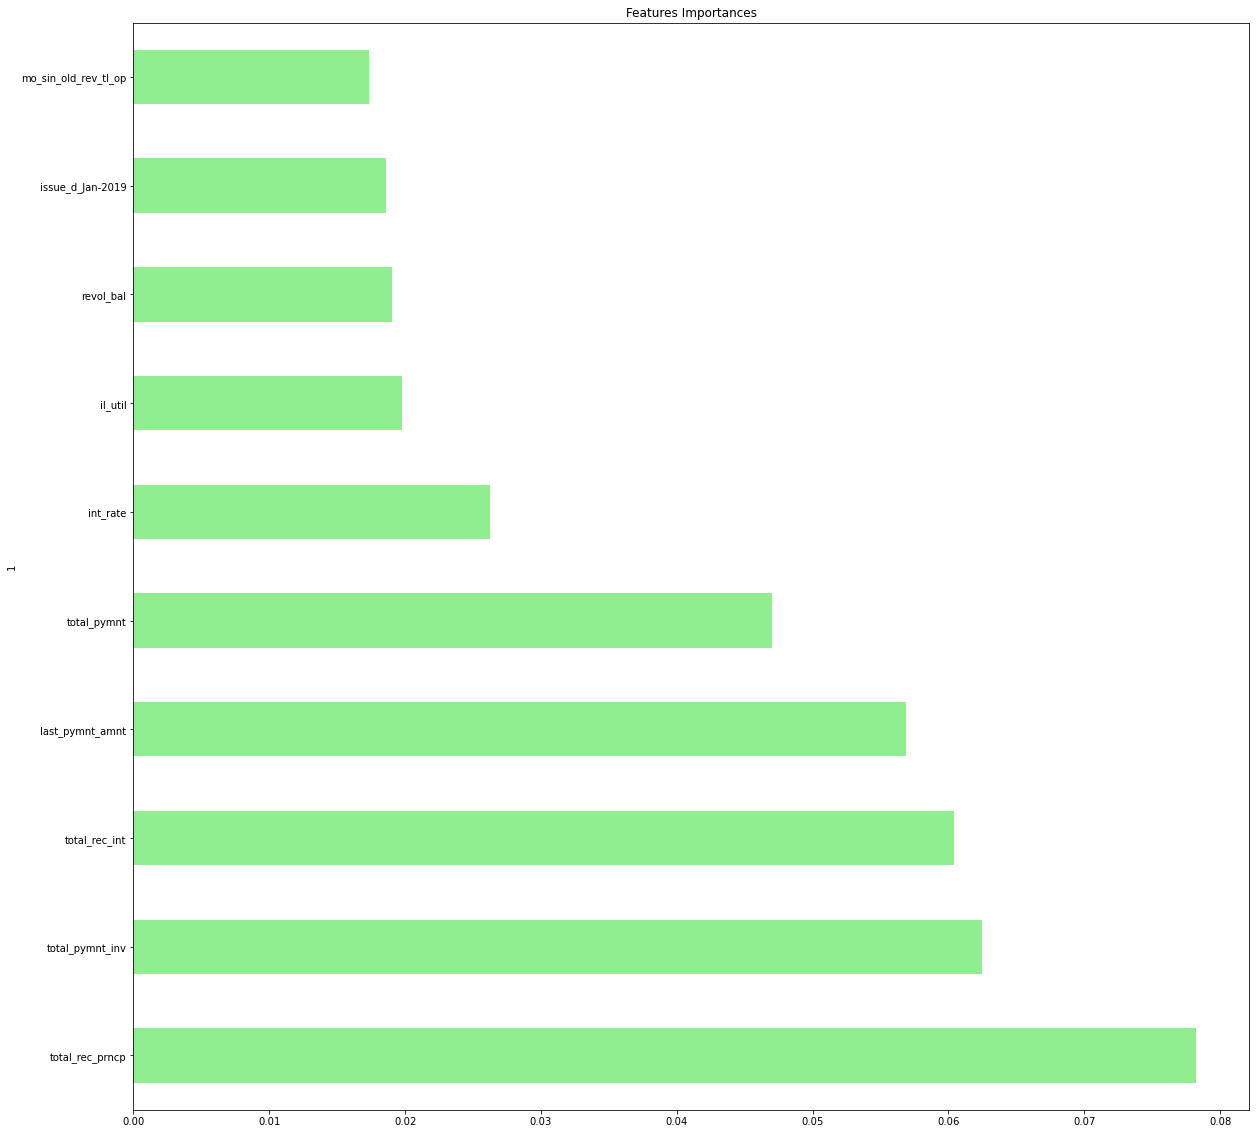

In [19]:
# Visualize the top 10 features by importance
importances_df = pd.DataFrame(sorted(zip(brf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
importances_sorted[:10].plot(kind='barh', color='lightgreen', title= 'Features Importances', figsize=(20,20), legend=False)

### Easy Ensemble Classifier

In [20]:
# Train the Classifier
eec = EasyEnsembleClassifier(n_estimators=100,random_state=1)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [21]:
# Calculated the balanced accuracy score
y_pred_eec = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred_eec)

0.8433701568423639

In [22]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_eec)

array([[   72,    15],
       [ 2411, 14707]])

In [23]:
cm_eec = confusion_matrix(y_test, y_pred_eec)
cm__eec_df = pd.DataFrame(
    cm_eec, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"]
)
cm__eec_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,72,15
Actual Low Risk,2411,14707


In [24]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.83      0.86      0.06      0.84      0.71        87
   low_risk       1.00      0.86      0.83      0.92      0.84      0.71     17118

avg / total       0.99      0.86      0.83      0.92      0.84      0.71     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    Answer : The Easy Ensemble Classifier model had the best balanced accuracy score.
   The Easy Ensemble Classifier model had a balanced accuracy score of 0.8433701568423639 compared to the Balanced Random Forest Classifier which had a balanced accuracy score 0.7794578000169211.



2. Which model had the best recall score?

    Answer : The Balanced Random Forest Classifier model had a higher recall score of 0.87 as compared to the Easy Ensemble Classifier model which had a overall recall score of 0.86. 



3. Which model had the best geometric mean score?

    Answer : The Easy Ensemble Classifier model had the best geometric mean score.


4. What are the top three features?

    Answer : The top three features are:
    1. total_rec_prncp, 
    2. total_pymnt_inv and 
    3. total_rec_int.